# 1. 문서 요약 데이터셋에서 핵심 데이터만 추출 후 데이터셋 재구성

### 문서요약텍스트 데이터셋 불러오기

In [1]:
!unzip "/content/sample_data/docsum"

Archive:  /content/sample_data/docsum.zip
   creating: Training/
  inflating: Training/법률_train_original.zip  
  inflating: Training/사설_train_original.zip  
  inflating: Training/신문기사_train_original.zip  
   creating: Validation/
  inflating: Validation/법률_valid_original.zip  
  inflating: Validation/사설_valid_original.zip  
  inflating: Validation/신문기사_valid_original.zip  


### 법률, 사설, 신문기사 서브데이터셋 압축 해제

In [2]:
!unzip "/content/Training/법률_train_original" -d "/content/Training/법률_train"
!unzip "/content/Training/사설_train_original" -d "/content/Training/사설_train"
!unzip "/content/Training/신문기사_train_original" -d "/content/Training/신문기사_train"
!unzip "/content/Validation/법률_valid_original" -d "/content/Validation/법률_valid"
!unzip "/content/Validation/사설_valid_original" -d "/content/Validation/사설_valid"
!unzip "/content/Validation/신문기사_valid_original" -d "/content/Validation/신문기사_valid"


Archive:  /content/Training/법률_train_original.zip
  inflating: /content/Training/법률_train/train_original.json  
Archive:  /content/Training/사설_train_original.zip
  inflating: /content/Training/사설_train/train_original.json  
Archive:  /content/Training/신문기사_train_original.zip
  inflating: /content/Training/신문기사_train/train_original.json  
Archive:  /content/Validation/법률_valid_original.zip
  inflating: /content/Validation/법률_valid/valid_original.json  
Archive:  /content/Validation/사설_valid_original.zip
  inflating: /content/Validation/사설_valid/valid_original.json  
Archive:  /content/Validation/신문기사_valid_original.zip
  inflating: /content/Validation/신문기사_valid/valid_original.json  


### 압축 폴더 삭제

In [3]:
!rm -rf "Training/법률_train_original.zip"
!rm -rf "Training/사설_train_original.zip"
!rm -rf "Training/신문기사_train_original.zip"
!rm -rf "Validation/법률_valid_original.zip"
!rm -rf "Validation/사설_valid_original.zip"
!rm -rf "Validation/신문기사_valid_original.zip"

### 압축 해제 데이터셋에 구성된 모든 '.DS_Store' 파일 삭제

In [4]:
!find "./Training" -name '.*' -delete
!find "./Validation" -name '.*' -delete

### 문서요약텍스트 데이터셋 핵심 데이터 추출

In [1]:
import os
import fnmatch
import json
import numpy as np
from itertools import chain
from datasets import DatasetDict, Dataset
import random

In [2]:
def load_docsum_dataset(json_data, path, text, label):
    key_name = "news"
    if "사설" in json_data['name']:
        key_name = "magazine"
    elif "법률" in json_data['name']:
        key_name = "law"
    for doc in json_data['documents']:
        origin = [info['sentence'] for info in list(chain.from_iterable(doc['text']))]
        summary = doc['abstractive'][0]
        summary = summary.replace('\n', ' ').strip()
        text[key_name].append(origin)
        label[key_name].append(summary)

def get_subdirectories(path, text, label):
  if fnmatch.fnmatch(path, "*.json"):
    with open(path, 'r', encoding='utf-8') as f:
      json_data = json.load(f)
      load_docsum_dataset(json_data, path, text, label)
    return
  subpaths = os.listdir(path)
  for subpath in subpaths:
    subpath = os.path.join(path, subpath)
    get_subdirectories(subpath, text, label)

In [17]:
def convert_to_DatasetDict(data):
  dataset = Dataset.from_dict(data)
  train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
  train_valid_split = train_test_split["train"].train_test_split(test_size=0.25, seed=42)
  dataset = DatasetDict({
      "train": train_valid_split["train"],
      "valid": train_valid_split["test"],
      "test": train_test_split["test"]
  })
  return dataset

In [18]:
def create_files(dir_name, dataset):
    train_valid_test = ["train", "valid", "test"]
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
    for cur in train_valid_test:
        with open(f'{dir_name}/{cur}.json', 'w', encoding='utf-8') as f:
            json.dump(dataset[cur].to_dict(), f, ensure_ascii=False, indent=4)

In [19]:
try:
    docsum_train = 'Training'
    docsum_valid = 'Validation'
    text = {'law': [], 'magazine': [], 'news': []}
    label = {'law': [], 'magazine': [], 'news': []}
    get_subdirectories(docsum_train, text, label)
    get_subdirectories(docsum_valid, text, label)
    for k, v in text.items():
        new_dataset_dict = {'text': v, 'label': label[k]}
        dataset = convert_to_DatasetDict(new_dataset_dict)
        create_files(k, dataset)

except FileNotFoundError as err:
    print(err)
except PermissionError:
    print(f"You do not have permission to access the directory '{docsum_train}'.")
except Exception as e:
    print(f"An error occurred: {e}")

### 법률, 사설, 신문기사별 train, valid, test 데이터로 분할

# 2. 학습 전 모델의 ROUGE 평가지표 측정

In [1]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast
import torch

/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# 비교적 모델 파라미터가 작은 모델 선정(77M)
model_ckpt = 'paust/pko-t5-small'
tokenizer = T5TokenizerFast.from_pretrained(model_ckpt)
model = T5ForConditionalGeneration.from_pretrained(model_ckpt)

/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/site-packages/transformers/modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are

In [3]:
import evaluate

# evaluate 라이브러리에서 rouge metric을 로드
def compute_rouge_scores(references, candidate):
  # references: 참조(실제) 요약 텍스트
  # candidate:  생성된 후보(예측) 요약 텍스트
  rouge = evaluate.load("rouge")
  scores = rouge.compute(
      predictions=candidate,
      references=references,
      rouge_types=["rouge1", "rouge2", "rougeL", "rougeLsum"],
      use_aggregator=True,
      use_stemmer=True,
  )
  return scores

In [4]:
from datasets import load_dataset
from itertools import islice
import json

In [5]:
# 모델의 손실 측정
domain_name = 'law'

domain_data = {
    'train': f'{domain_name}/train.jsonl',
    'valid': f'{domain_name}/valid.jsonl',
    'test': f'{domain_name}/test.jsonl'
}

test_dataset = load_dataset('json', data_files=domain_data, split='test', streaming=True)
input_ids = tokenizer(
    [f"summarize: {' '.join(data['text']).rstrip()}" for data in islice(test_dataset, 20)],
    padding='max_length', max_length=2048,
    truncation=True,
    return_tensors='pt'
)['input_ids']
labels = tokenizer([data['label'] for data in islice(test_dataset, 20)], padding='max_length', max_length=512, truncation=True, return_tensors='pt')['input_ids']

# 예측 요약문과 참조 요약문을 가지고 ROUGE(ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-LSUM) 측정
predictions_ids = model.generate(input_ids=input_ids, max_length=512)
predictions = tokenizer.batch_decode(predictions_ids, skip_special_tokens=True)
references = [data['label'] for data in islice(test_dataset, 20)]
print(compute_rouge_scores(references, predictions))

{'rouge1': 0.1, 'rouge2': 0.008, 'rougeL': 0.11481481481481481, 'rougeLsum': 0.11296296296296296}


# 3. 토큰 길이 확인

### input 토큰 길이, label 토큰 길이 확인

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

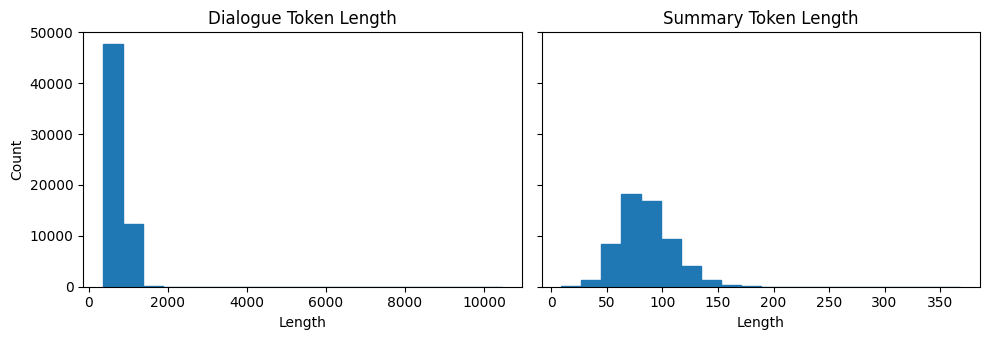

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

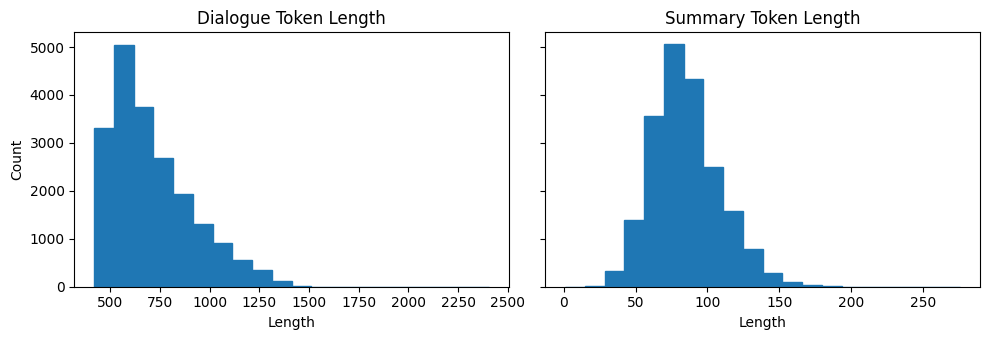

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

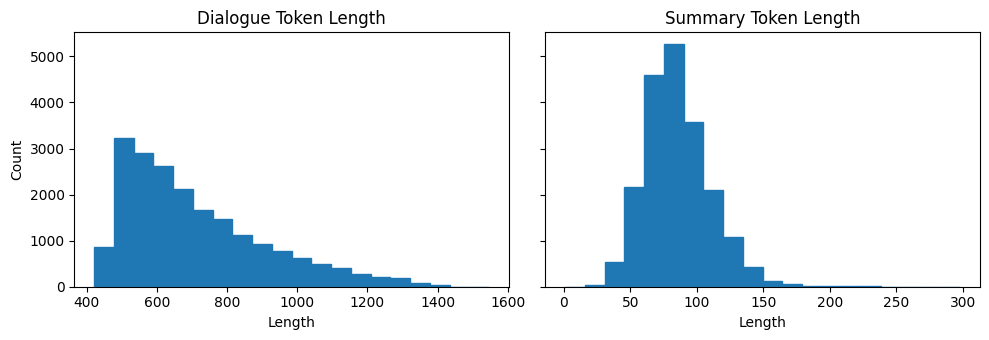

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 60000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
})

In [9]:
import matplotlib.pyplot as plt
import itertools

def tokenize_for_check_length(batch):
  model_ckpt = 'paust/pko-t5-small'
  tokenizer = T5TokenizerFast.from_pretrained(model_ckpt)
  model_inputs = tokenizer("")
  model_inputs['input_ids'].pop()
  model_inputs['attention_mask'].pop()
  origin_len = []
  for text in batch['text']:
    tmp = tokenizer(text)
    tmp_input_ids = list(itertools.chain(*tmp['input_ids']))
    while 1 in tmp_input_ids:
      tmp_input_ids.remove(1)
    tmp_input_ids.append(1)
    origin_len.append(len(tmp_input_ids))
  label_len = [len(tokenizer.encode(summary)) for summary in batch['label']]
  fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
  axes[0].hist(origin_len, bins=20, color="C0", edgecolor="C0")
  axes[0].set_title('Dialogue Token Length')
  axes[0].set_xlabel("Length")
  axes[0].set_ylabel("Count")
  axes[1].hist(label_len, bins=20, color="C0", edgecolor="C0")
  axes[1].set_title("Summary Token Length")
  axes[1].set_xlabel("Length")
  plt.tight_layout()
  plt.show()

# dataset = convert_to_DatasetDict(data)
dataset.map(tokenize_for_check_length, batched=True, batch_size=None)

In [ ]:
from transformers import T5TokenizerFast, T5ForConditionalGeneration
import itertools

model_ckpt = 'paust/pko-t5-small'
tokenizer = T5TokenizerFast.from_pretrained(model_ckpt)
model = T5ForConditionalGeneration.from_pretrained(model_ckpt)
encoder_max_len = tokenizer.model_max_length = 2048
decoder_max_len = 512

/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def pad_sequences(model_inputs):
    """
    sequences: List of List of token ids (e.g., [[1, 2], [3, 4, 5]])
    pad_token_id: token id to use for padding (default=0)
    """
    encoder_max_length = tokenizer.model_max_length
    decoder_max_length = 512

    padded_input_ids = [
        seq + [0] * (encoder_max_length - len(seq)) for seq in model_inputs['input_ids']
    ]

    padded_attention_masks = [
        seq + [0] * (encoder_max_length - len(seq)) for seq in model_inputs['attention_mask']
    ]

    model_inputs['input_ids'] = padded_input_ids
    model_inputs['attention_mask'] = padded_attention_masks

def tokenize(batch):
  model_inputs = tokenizer("")
  model_inputs['input_ids'].pop()
  model_inputs['attention_mask'].pop()
  for idx, text in enumerate(batch['text']):
    text[0] = "summarize: " + text[0]
    tmp = tokenizer(text)
    tmp_input_ids = list(itertools.chain(*tmp['input_ids']))
    tmp_attention_mask = list(itertools.chain(*tmp['attention_mask']))
    while 1 in tmp_input_ids:
      tmp_input_ids.remove(1)
      tmp_attention_mask.pop()
    tmp_input_ids.append(1)
    tmp_attention_mask.append(1)
    if len(tmp_input_ids) > tokenizer.model_max_length:
      tmp_input_ids = tmp_input_ids[:tokenizer.model_max_length]
      tmp_attention_mask = tmp_attention_mask[:tokenizer.model_max_length]
    model_inputs['input_ids'].append(tmp_input_ids)
    model_inputs['attention_mask'].append(tmp_attention_mask)
  model_inputs['labels'] = tokenizer(batch['label'], padding='max_length', max_length=512, truncation=True)['input_ids']
  return model_inputs


In [8]:
# 데이터셋 전처리 (배치 처리)
dataset = convert_to_DatasetDict(data)
tokenized_datasets = dataset.map(tokenize, batched=True, batch_size=None)
tokenized_datasets = tokenized_datasets.map(pad_sequences, batched=True, batch_size=None)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'labels', 'attention_mask'])

Map:   0%|          | 0/219113 [00:00<?, ? examples/s]

Map:   0%|          | 0/73038 [00:00<?, ? examples/s]

Map:   0%|          | 0/73038 [00:00<?, ? examples/s]

Map:   0%|          | 0/219113 [00:00<?, ? examples/s]

Map:   0%|          | 0/73038 [00:00<?, ? examples/s]

Map:   0%|          | 0/73038 [00:00<?, ? examples/s]

# 4. 모델 훈련 준비 작업

### 1) 모델 초기화

In [1]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast

/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# 비교적 모델 파라미터가 작은 모델 선정(77M)
model_ckpt = 'paust/pko-t5-small'
tokenizer = T5TokenizerFast.from_pretrained(model_ckpt)
model = T5ForConditionalGeneration.from_pretrained(model_ckpt)

/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/site-packages/transformers/modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are

In [3]:
tokenizer.pad_token_id

0

### 2) 데이터셋 구축

In [4]:
from datasets import load_dataset
import torch
from torch.utils.data import IterableDataset
from torch.utils.data.dataloader import DataLoader

In [5]:
domain_name = 'law'

domain_data = {
    'train': f'{domain_name}/train.jsonl',
    'valid': f'{domain_name}/valid.jsonl',
    'test': f'{domain_name}/test.jsonl'
}

seq_length = {
    'encoder': 2048,
    'decoder': 512
}

In [23]:
class Vetorizer(IterableDataset):
    def __init__(self, tokenizer, dataset, seq_length, total_count):
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.seq_length = seq_length
        self.total_count = total_count
    
    def __iter__(self):
        iterator = iter(self.dataset)
        while True:
            try:
                data = next(iterator)
                data['text'][0] = "summarize: " + data['text'][0]
                text_concatenated = " ".join(data['text'])
                label = data['label']
                text_tokenized = tokenizer(text_concatenated, padding='max_length', max_length=self.seq_length.encoder, truncation=True, return_tensors='pt')
                label_tokenized = tokenizer(label, padding='max_length', max_length=self.seq_length.decoder, truncation=True, return_tensors='pt')
                data = {
                    'input_ids': text_tokenized['input_ids'],
                    'attention_mask': text_tokenized['attention_mask'],
                    'labels': label_tokenized['input_ids'],
                }
                yield data
            except StopIteration:
                iterator = iter(self.dataset)

    def __len__(self):
        return self.total_count

In [24]:
import gc

In [27]:
def create_dataset(tokenizer, domain_data, args, seq_length):
    train_data = load_dataset('json', data_files=domain_data, split='train', streaming=True)
    no_iter_train_data = load_dataset('json', data_files=domain_data, split='train', streaming=False)
    total_train_data_cnt = len(no_iter_train_data)
    del no_iter_train_data
    gc.collect()

    eval_data = load_dataset('json', data_files=domain_data, split='valid', streaming=True)
    no_iter_eval_data = load_dataset('json', data_files=domain_data, split='valid', streaming=False)
    total_eval_data_cnt = len(no_iter_eval_data)
    del no_iter_eval_data
    gc.collect()
    
    train_dataset = Vetorizer(tokenizer, train_data, seq_length, total_train_data_cnt)
    eval_dataset = Vetorizer(eval_data, eval_data, seq_length, total_train_data_cnt)
    
    return train_dataset, eval_dataset

### 3) 훈련 루프 정의

In [8]:
import evaluate
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

In [36]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.basic_variant import BasicVariantGenerator
from ray.tune import JupyterNotebookReporter
from transformers import TrainerCallback

In [35]:
import transformers

print(transformers.__version__)

4.33.3


In [11]:
# 2) 사용자 정의 함수 (원본)
def compute_rouge_scores(references, candidate):
    # references: List[str], candidate: List[str]
    rouge = evaluate.load("rouge")
    scores = rouge.compute(
        predictions=candidate,
        references=references,
        rouge_types=["rouge1", "rouge2", "rougeL", "rougeLsum"],
        use_stemmer=True,
        # evaluate 라이브러리 최신 버전에서는 use_aggregator가 True가 기본입니다.
    )
    return scores  # {'rouge1':Score(...), ...}

# 3) Trainer용 compute_metrics 래퍼
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # 3‑1) 토큰 → 텍스트 복원
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # 3‑2) 위 커스텀 함수 호출
    raw_scores = compute_rouge_scores(
        references=decoded_labels,
        candidate=decoded_preds
    )

    # 3‑3) Score 객체에서 fmeasure 만 빼와 %로 변환
    #    Score.mid.fmeasure 혹은 Score.fmeasure 속성을 사용
    flat_scores = {}
    for key, score in raw_scores.items():
        # evaluate 0.4.x 기준: score.mid.fmeasure
        # evaluate 0.3.x 기준: score.fmeasure
        f = getattr(score.mid, "fmeasure", None) or getattr(score, "fmeasure")
        flat_scores[key] = f * 100

    return flat_scores

In [12]:
args = Seq2SeqTrainingArguments(
    output_dir="./new_text_summarize_model",
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=100,
    save_steps=500,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=3e-5,
    warmup_steps=500,
    fp16=torch.cuda.is_available(),
    predict_with_generate=True,
    generation_max_length=512,
    generation_num_beams=4
)

In [37]:
from transformers import TrainerCallback

class MyTuneReportCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if not metrics:
            return control
        from ray import tune
        # compute_metrics 가 리턴한 eval_* 키들 중 필요한 것만 보고
        tune.report(
            eval_loss=metrics.get("eval_loss"),
            eval_rouge1=metrics.get("eval_rouge1"),
            eval_rouge2=metrics.get("eval_rouge2"),
            eval_rougeL=metrics.get("eval_rougeL"),
        )
        return control


In [38]:
def model_init():
    return T5ForConditionalGeneration.from_pretrained(model_ckpt)

def make_trainer(training_args, train_dataset, eval_dataset, tokenizer, compute_metrics):
    return Seq2SeqTrainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,   # 미리 로드된 Dataset 객체
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorForSeq2Seq(
            tokenizer,
            model=None,  # 또는 이 인자를 생략
            label_pad_token_id=tokenizer.pad_token_id
        ),
        compute_metrics=compute_metrics,
        callbacks=[MyTuneReportCallback()]
    )

train_dataset, eval_dataset = create_dataset(tokenizer, domain_data, args, seq_length)
trainer = make_trainer(args, train_dataset, eval_dataset, tokenizer, compute_metrics)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [39]:
ray_hp_space = {
    "learning_rate":        tune.loguniform(1e-6, 5e-5),
    "weight_decay":         tune.uniform(0.01, 0.1),
    "per_device_train_batch_size": tune.choice([4, 8, 16]),
    "num_train_epochs":     tune.choice([1, 2, 3]),
    "warmup_steps":         tune.randint(0, 500),
}

scheduler = ASHAScheduler(
    metric="eval_rougeLsum",
    mode="max",
    max_t=3,               # num_train_epochs 상한
    grace_period=1,        # 1 Epoch은 모두 돌려봐야
    reduction_factor=2
)

search_alg = BasicVariantGenerator()

In [40]:
import os
from pathlib import Path

abs_path = os.path.abspath("ray_text_summarize_results")
file_uri = Path(abs_path).as_uri()
print(file_uri)

file:///scratch/e1430a14/workspace/text_summary/ray_pilot_results


In [41]:
reporter = JupyterNotebookReporter(
    overwrite=True,
    metric_columns=[
        "training_iteration",
        "eval_loss",
        "eval_rouge1",
        "eval_rouge2",
        "eval_rougeL",
        "epoch",
    ]
)

In [ ]:
ray.init(include_dashboard=False)

In [ ]:
best_hp = trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    hp_space=lambda _: ray_hp_space,
    n_trials=10,
    resources_per_trial={"cpu":64, "gpu":8},
    scheduler=scheduler,
    search_alg=search_alg,
    storage_path=file_uri,
    name="best_hp",
    progress_reporter=reporter
)

best_hp_dir_name = "best_hp_for_new_text_summarize_model"
os.makedirs(best_hp_dir_name, exist_ok=True)
with open(f"{best_hp_dir_name}/best_hp.json", "w") as f:
    json.dump(best_hp.hyperparameters, f, indent=2)

print("== Best Hyperparameters ==")
print(best_hp.hyperparameters, best_hp.objective)

2025-04-26 01:34:47,601	ERROR services.py:1350 -- Failed to start the dashboard , return code 0
2025-04-26 01:34:47,603	ERROR services.py:1375 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#logging-directory-structure' to find where the log file is.
2025-04-26 01:34:47,605	ERROR services.py:1419 -- 
The last 20 lines of /tmp/ray/session_2025-04-26_01-34-35_230881_24661/logs/dashboard.log (it contains the error message from the dashboard): 
2025-04-26 01:34:47,211	WARNING dashboard.py:264 -- The dashboard on node jupyter01 failed with the following error:
Traceback (most recent call last):
  File "/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/site-packages/ray/dashboard/dashboard.py", line 255, in <module>
    loop.run_until_complete(dashboard.run())
  File "/scratch/e1430a14/.conda/envs/notebook/lib/python3.10/asyncio/base_events.

(autoscaler +1h1m22s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +1h1m22s) Error: No available node types can fulfill resource request {'GPU': 8.0, 'CPU': 64.0}. Add suitable node types to this cluster to resolve this issue.


In [ ]:
from dataclasses import replace

best_config = best_hp.hyperparameters
final_args = replace(
    args,
    learning_rate=best_config['learning_rate'],
    weight_decay=best_config['weight_decay'],
    per_device_train_batch_size=best_config['per_device_train_batch_size'],
    num_train_epochs=best_config['num_train_epochs'],
    warmup_steps=best_config['warmup_steps']
)

In [ ]:
final_model = T5ForConditionalGeneration.from_pretrained(model_ckpt)

In [ ]:
final_trainer = Seq2SeqTrainer(
    model=final_model,              # ← 여기서 model_init이 아니라 model로
    args=final_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(
        tokenizer,
        model=None,
        label_pad_token_id=tokenizer.pad_token_id
    ),
    compute_metrics=compute_rouge
)

In [ ]:
final_trainer.train()

In [ ]:
import os
import json

def backup_trainer(trainer, backup_dir: str = "./text_summarize_final_trainer_backup"):
    """
    Trainer와 연관된 모델, 토크나이저, 학습 인자, 상태, 로그 기록을 로컬에 백업합니다.

    Args:
        trainer: Seq2SeqTrainer 또는 Trainer 인스턴스
        backup_dir: 백업을 저장할 디렉토리 경로
    """
    # 1) 백업 디렉토리 생성
    os.makedirs(backup_dir, exist_ok=True)

    # 2) 모델, 토크나이저 저장
    trainer.save_model(backup_dir)               # pytorch_model.bin, config.json 등
    if trainer.tokenizer is not None:
        trainer.tokenizer.save_pretrained(backup_dir)

    # 3) Trainer state 저장 (trainer_state.json)
    trainer.save_state()

    # 4) TrainingArguments를 JSON으로 저장
    args_path = os.path.join(backup_dir, "text_summarize_training_args.json")
    trainer.args.to_json_file(args_path)

    # 5) 로그 히스토리(log_history)를 JSON으로 저장
    log_history = trainer.state.log_history
    logs_path = os.path.join(backup_dir, "text_summarize_log_history.json")
    with open(logs_path, "w", encoding="utf-8") as f:
        json.dump(log_history, f, indent=2, ensure_ascii=False)

    print(f"백업 완료: {backup_dir}")

backup_trainer(final_trainer)